In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, LeaveOneGroupOut, PredefinedSplit, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, lasso_path
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
from utils import DATA_PATH, DATA_CLEAN_PATH, RESULTS_PATH
from utils import set_plt_settings, GEO_CRS
from train_functions import scoring_default, run_cv

set_plt_settings()
write_mode = True

## Make analytic datasets

In [3]:
# read in
df = pd.read_csv(DATA_CLEAN_PATH / 'analysis_df.csv')

# make target and features
X = df.loc[:, [col for col in df.columns if col.startswith(('ndvi', 'lst'))]]
y = (df.total / df.area_km).to_numpy() # short tons per km^2
g_county = df.countyfp.to_numpy()
g_state = df.statefp.to_numpy()
g_report = (df.last_report*1).to_numpy()

# scale features
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Generate hold-out test data and splitters

In [4]:
idx_train, idx_test = train_test_split(range(len(y)), test_size=0.10, random_state=1, shuffle=True, stratify=None)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]
g_county_train = g_county[idx_train]
g_state_train = g_state[idx_train]
g_report_train = g_report[idx_train]

In [5]:
splitter_countyKFold = GroupKFold(5)
splitter_stateLOO = LeaveOneGroupOut()
splitter_lastReport = PredefinedSplit(g_report_train)
scoring_report = scoring_default.copy()
scoring_report.pop('r_squared')

# split_name, splitter, groups, scoring = 'countyKFold', splitter_countyKFold, g_county_train, scoring_default
split_name, splitter, groups, scoring = 'stateLOO', splitter_stateLOO, g_state_train, scoring_default
# split_name, splitter, groups, scoring = 'lastReport', splitter_lastReport, g_report_train, scoring_report

## Cross validate contending models

In [6]:
# dummy regressor
params={}
cv_mean = run_cv(X=X_train, y=y_train, estimator=DummyRegressor(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_mean['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model     DummyRegressor()
params                  {}
rmse           4520.385486
mae            3934.652622
r_sq            -24.537138
Name: 0, dtype: object

In [7]:
# linear regression
params={}
cv_lm = run_cv(X=X_train, y=y_train, estimator=LinearRegression(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_lm['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model     LinearRegression()
params                    {}
rmse             2213.859649
mae              1734.920845
r_sq               -1.692585
Name: 0, dtype: object

In [8]:
# Elastic Net
# params={'alpha':[j*(10**i) for i in range(3, 5) for j in range(1, 9)], 'l1_ratio':[0.1, 0.25, 0.5, 0.9]}
# params={'alpha':[1000], 'l1_ratio':[0.9]} # county
params={'alpha':[3600], 'l1_ratio':[0.95]} # state
# params={'alpha':[1000], 'l1_ratio':[0.9]} # report
cv_enet = run_cv(X=X_train, y=y_train, estimator=ElasticNet(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_enet['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model                          ElasticNet()
params    {'alpha': 3600, 'l1_ratio': 0.95}
rmse                            2387.059452
mae                             1886.513266
r_sq                              -4.672777
Name: 0, dtype: object

In [9]:
# decision tree regression
# params={'min_samples_leaf': [8, 10, 12], 'max_depth': [10, 20, 30]} # 10 10
# params={'min_samples_leaf': [10], 'max_depth': [10]} # county
params={'min_samples_leaf': [8], 'max_depth': [10]} # state
# params={'min_samples_leaf': [10], 'max_depth': [9]} # report
cv_dt = run_cv(X=X_train, y=y_train, estimator=DecisionTreeRegressor(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_dt['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model                      DecisionTreeRegressor()
params    {'max_depth': 10, 'min_samples_leaf': 8}
rmse                                   1942.621029
mae                                     1446.02572
r_sq                                     -0.015107
Name: 0, dtype: object

In [10]:
# random forest regression
# params={'min_samples_leaf': [2, 5, 8], 'max_depth': [None, 100, 50]} # 
# params={'min_samples_leaf': [2], 'max_depth': [None]} # county
params={'min_samples_leaf': [2], 'max_depth': [50]} # state
# params={'min_samples_leaf': [1], 'max_depth': [None]} # report
cv_rf = run_cv(X=X_train, y=y_train, estimator=RandomForestRegressor(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_rf['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model                      RandomForestRegressor()
params    {'max_depth': 50, 'min_samples_leaf': 2}
rmse                                   1591.509903
mae                                    1202.985811
r_sq                                      0.364029
Name: 0, dtype: object

In [11]:
# xgboost regression
# params={'reg_alpha':[.01, .1, 1, 10, 100], 'reg_lambda':[0.1, .1, 1, 10, 100], 'tree_method':['approx', 'hist']} # .1, 100 hist
# params={'reg_alpha':[0.1], 'reg_lambda':[90], 'tree_method':['hist']} # county
params={'reg_alpha':[10], 'reg_lambda':[10], 'tree_method':['approx']} # state
# params={'reg_alpha':[1], 'reg_lambda':[1], 'tree_method':['approx']} # report
cv_xgb = run_cv(X=X_train, y=y_train, estimator=XGBRegressor(objective="reg:squarederror"), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_xgb['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


model     XGBRegressor(base_score=None, booster=None, ca...
params    {'reg_alpha': 10, 'reg_lambda': 10, 'tree_meth...
rmse                                            1681.852565
mae                                              1273.37118
r_sq                                               0.203071
Name: 0, dtype: object

In [ ]:
# N-layer fully connected neural net
# params={'hidden_layer_sizes': [(1000), (4000), (4000, 1000)]} # 
# params={'hidden_layer_sizes': [(4000, 1000)]} # county
params={'hidden_layer_sizes': [(4000, 1000)]} # state
# params={'hidden_layer_sizes': [(4000)]} # report
cv_fcnet = run_cv(X=X_train, y=y_train, estimator=MLPRegressor(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_fcnet['min']

Fitting 48 folds for each of 1 candidates, totalling 48 fits


## Summarize and save

In [ ]:
# All results (for the records)
# setup
key='all'
filename = f'cv_{key}_{split_name}.csv'
filepath = RESULTS_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
# make and save
cv_all = pd.concat((cv_mean[key], cv_lm[key], cv_enet[key], cv_dt[key], cv_rf[key], cv_xgb[key], cv_fcnet[key]))
if write_mode:
    cv_all.to_csv(filepath, index=False)

# min results
# setup
key='min'
filename = f'cv_{key}_{split_name}.csv'
filepath = RESULTS_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
# make and save
cv_min = pd.DataFrame((cv_mean[key], cv_lm[key], cv_enet[key], cv_dt[key], cv_rf[key], cv_xgb[key], cv_fcnet[key]))
if write_mode:
    cv_min.to_csv(filepath, index=False)

In [ ]:
cv_min

# Final summary table

In [ ]:
# read in all results and summarize
results_min = pd.DataFrame()
for name in ['countyKFold', 'stateLOO', 'lastReport']:
    m = pd.read_csv(RESULTS_PATH / f'cv_min_{name}.csv')
    m.loc[:, 'split'] = name
    order_cols = ['split', 'model', 'params']
    new_col_order = order_cols + m.columns.drop(order_cols).tolist()
    m = m[new_col_order]
    results_min = pd.concat((m, results_min))
    
results_min

# Wtih selected model, visualize error in cross validation

In [44]:
# out of state predictions
split_name, splitter, groups = 'stateLOO', splitter_stateLOO, g_state_train
# final parameters
final_params = params={'reg_alpha':10, 'reg_lambda':10, 'tree_method':'approx'}
final_model = XGBRegressor(objective="reg:squarederror", **final_params)
final_params = {}
final_model = LinearRegression(**final_params)

# cross validate
y_pred = cross_val_predict(
    estimator=final_model,
    X=X_train,
    y=y_train,
    groups=groups,
    cv=splitter,
    verbose=0,
    method='predict')

In [54]:
# calculate error
error = y_pred - y_train
error_rel = error / y_train * 100

# for visualization purposes, drop outliers
drop_pctl = 10
error_rel[(error_rel < np.percentile(error_rel, drop_pctl)) | (error_rel > np.percentile(error_rel, 100-drop_pctl))] = np.nan

In [55]:
# create columns and merge onto county data
fips_train = df.loc[idx_train, ['fips', 'last_report']]
fips_train.loc[:, 'y_pred_error'] = error
fips_train.loc[:, 'y_pred_error_rel'] = error_rel

c_filepath = str(DATA_PATH / 'county_shapefiles/cb_2018_us_county_5m.shp')
counties = gpd.read_file(c_filepath).to_crs(GEO_CRS)
counties.columns = counties.columns.str.lower()
counties.loc[:, 'fips'] = (counties.statefp + counties.countyfp).astype(int)
# drop non-contiguous us regions
counties = counties.loc[~counties.statefp.isin(['02', '15', '60', '66', '72', '69', '78'])]

# merge on FS data
county_fs = counties.merge(right=fips_train, how='right', on='fips')

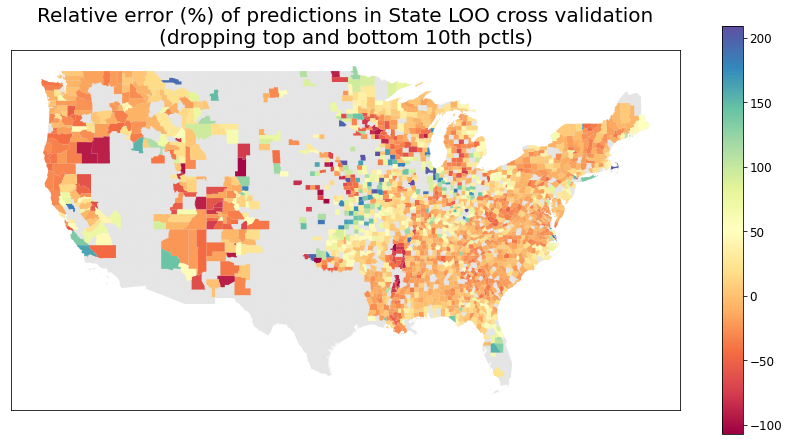

In [56]:
title = f'Relative error (%) of predictions in State LOO cross validation\n(dropping top and bottom {drop_pctl}th pctls)'
gdf = county_fs.loc[county_fs.last_report]
value_col = 'y_pred_error_rel'

fig, ax = plt.subplots(figsize=(15, 15))
counties.plot(ax=ax, color='grey', alpha=0.2)
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.5}, cmap='Spectral') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title(title)
plt.show()

# Performance of final model

In [57]:
# fit and predict model
final_params = params={'reg_alpha':10, 'reg_lambda':10, 'tree_method':'approx'}
final_model = XGBRegressor(objective="reg:squarederror", **final_params)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# calculate metrics
final_scores = {}
final_scores['RMSE'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_scores['MAE'] = mean_absolute_error(y_test, y_test_pred)
final_scores['R^2'] = r2_score(y_test, y_test_pred)
print(final_scores)

{'RMSE': 1139.6639434873275, 'MAE': 818.007232791594, 'R^2': 0.9161774332756615}


## True vs. predicted

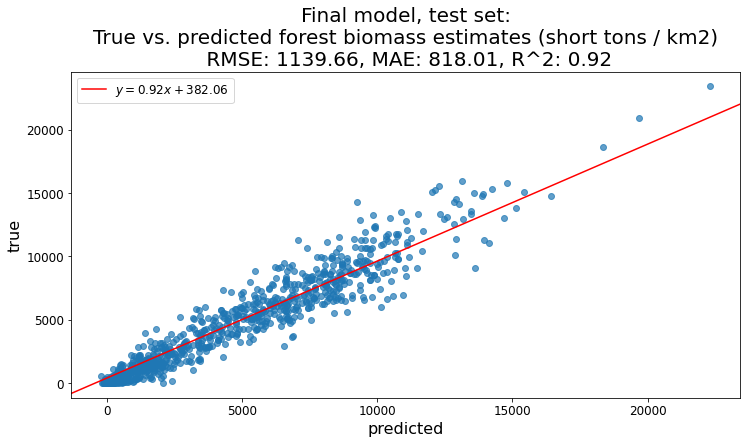

In [58]:
# plot predictions against actuals
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=y_test_pred, y=y_test, alpha=0.7)

# compute slope m and intercept b
m, b = np.polyfit(y_test, y_test_pred, deg=1)
# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

plt.legend()
plt.xlabel('predicted')
plt.ylabel('true')
newline = ','
plt.title(f'Final model, test set:\nTrue vs. predicted forest biomass estimates (short tons / km2)\n {", ".join(f"{k}: {final_scores[k]:0.2f}" for k in final_scores.keys())}')
plt.show()

## Prediction error

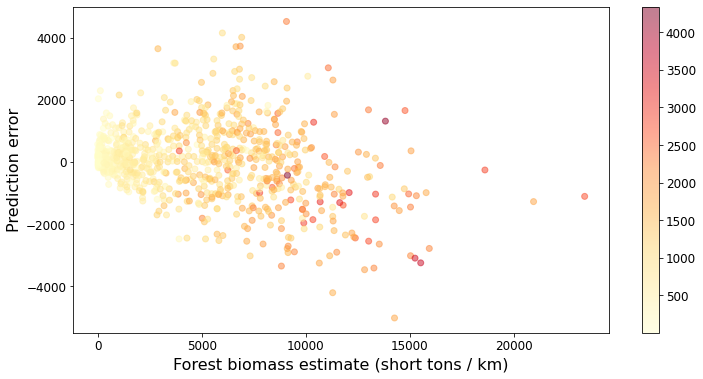

In [59]:
error = y_test_pred - y_test
error_rel = error / y_test * 100

fig, ax = plt.subplots(figsize=(12, 6))

df_test = df.loc[idx_test]

color_vals = (df_test.sampling_error / df_test.area_km).values
plt.scatter(x=y_test, y=error, c=color_vals, cmap='YlOrRd', alpha=0.5)
plt.xlabel('Forest biomass estimate (short tons / km)')
plt.ylabel('Prediction error')
plt.colorbar()
plt.show()

## Overall sample test

In [60]:
import scipy.stats as sps

In [61]:
# Country-level prediction
true_cbiomass = y_test.mean()
true_cbiomass_var = y_test.var()
pred_cbiomass = y_test_pred.mean()
pred_cbiomass_var = y_test_pred.var()

stat, pvalue = sps.levene(y_test, y_test_pred)
print('pvalue for levene test (H_0 of equal variance):', pvalue)

# Paired t-test

# Signed rank test



pvalue for levene test (H_0 of equal variance): 0.5623703498015657
